In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing Datasets

## MNIST (The one we are currently using for project)

In [ ]:
n_examples = 4000
IMAGE_SHAPE = (28, 28)
n_features = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

# Hack to select first batch
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize(IMAGE_SHAPE)])),
                            batch_size=n_examples, shuffle=True)


def create_dataset(train_loader, batch_num=0):    
  train_iter = iter(train_loader)  
  data = next(train_iter)
  for _ in range(batch_num):
    data = next(train_iter)
  dataset = (torch.reshape(torch.squeeze(data[0]),(n_examples,n_features)).numpy())
  return dataset

dataset = create_dataset(train_loader)
print(dataset.shape)

(4000, 784)


## CIFAR-10

In [ ]:
IMAGE_SHAPE = (32, 32)

full_dataset = torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                                            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Grayscale(), torchvision.transforms.Resize(IMAGE_SHAPE)]))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /files/cifar-10-python.tar.gz to /files/


In [ ]:
train_loader = torch.utils.data.DataLoader(full_dataset)

label_to_img = {}
for im, label_t in train_loader:
    label = label_t[0].item()
    if label in label_to_img:
        label_to_img[label].append(im.numpy())
    else:
        label_to_img[label] = [im.numpy()]

In [ ]:
chosen_label = 3
n_features = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]
n_examples = len(label_to_img[chosen_label])

dataset = np.asarray(label_to_img[chosen_label]).reshape((n_examples, n_features))

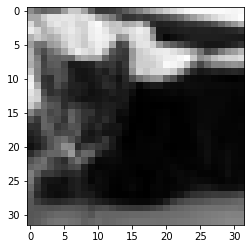

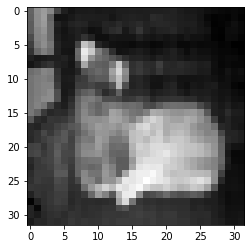

In [ ]:
for i in range(2):
    plt.imshow(dataset[i].reshape(32, 32), cmap="gray")
    plt.show()

## Fashion MNIST

In [ ]:
n_examples = 5000
IMAGE_SHAPE = (28, 28)
n_features = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize(IMAGE_SHAPE)])),
                            batch_size=n_examples, shuffle=True)


def create_dataset(train_loader):      
  data = next(iter(train_loader))
  dataset = (torch.reshape(torch.squeeze(data[0]),(n_examples,n_features)).numpy())

  return dataset

dataset = create_dataset(train_loader)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



# Utility Functions

In [ ]:
def plot_img_matrix(img):
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  plt.show()

def plot_image_vector(img):
  plot_img_matrix(np.reshape(img, IMAGE_SHAPE))

def plot_two_image_vector(img1, title1, img2, title2, **kwargs):
  plot_image_vectors([img1, img2], [title1, title2], **kwargs)

# Caveat: Only works with two or more images
def plot_image_vectors(imgs, titles, figsize=None, titlesize=12):
  actual_figsize = figsize if figsize else plt.rcParams["figure.figsize"]
  f, axes = plt.subplots(1, len(imgs), figsize=actual_figsize)
  for i in range(len(imgs)):
    img = np.reshape(imgs[i], IMAGE_SHAPE)
    axes[i].imshow(img, cmap='gray', interpolation='none')
    axes[i].set_title(titles[i], fontsize=titlesize)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
  plt.show()

def mean_l2diff(A, B):
    return np.mean(np.linalg.norm(A - B, ord=2, axis=1))

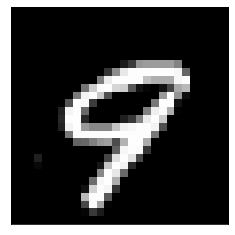

In [ ]:
plot_image_vector(dataset[0])

# Compression with Alternating Least Squares

We want to factor the dataset into two  $k$-rank matrices $E$ and $D$. $E$ will be the embedding matrix and $D$ will be the compression matrix. To do this, we must solve the following optimization problem. 
$$ \underset{E,D}{\text{minimize}} \quad \quad \sum_{u,i} \left(R_{u,i} - E_u^T D_i\right)^2 + \frac{\lambda}{2}\left(\sum_u ||E_u||^2 + \sum_i ||D_i||^2 \right)$$
where $R$ is the dataset.

Note that $E$ is a $M \times K$ matrix and $D$ is a $N \times k$ matrix.

Since this problem is biconvex, we can use alternating least squares to solve it.

In [ ]:
def ALS(R, k, lam, max_iter, tol, report = True):
  np.random.seed(0)

  X = np.random.normal(0, 1, (n_examples, k))
  Y = np.random.normal(0, 1, (n_features, k))

  prev_X_obj = 1e9
  cur_X_obj = np.linalg.norm(X, ord='fro')

  prev_Y_obj = 1e9
  cur_Y_obj = np.linalg.norm(Y, ord='fro')

  for it in tqdm(range(max_iter)):

    def log_progress():
      plot_image_vector((X @ Y.T)[0])
      print("\nRelative Change [X]: ", abs((prev_X_obj - cur_X_obj)/prev_X_obj))
      print("Relative Change [Y]: ", abs((prev_Y_obj - cur_Y_obj)/prev_Y_obj))

    if(abs((prev_X_obj - cur_X_obj)/prev_X_obj) < tol and
       abs((prev_Y_obj - cur_Y_obj)/prev_Y_obj) < tol):
      log_progress()
      break
 
    X = R @ Y @ np.linalg.inv(Y.T @ Y + lam * np.identity(k))
    Y = R.T @ X @ np.linalg.inv(X.T @ X + lam * np.identity(k))

    prev_X_obj = cur_X_obj 
    prev_Y_obj = cur_Y_obj

    cur_X_obj = np.linalg.norm(X, ord='fro')
    cur_Y_obj = np.linalg.norm(Y, ord='fro')

    if it % 50 == 0 and report:
        log_progress()

  if report:    
    plot_image_vector((X @ Y.T)[0])
  
  return X, Y

**Observations**

- Higher values of lambda tend to give more averaged out or blurred images. Try putting lambda = 20.
- Lower values of lambda leads to faster convergence of ALS.

In [ ]:
# Original Hyperparameters
lam = 1
comp_fact = 0.3
tol = 1e-7
maxit = 1000

# x20 Compression
lam = 1
comp_fact = 0.05
tol = 1e-7
maxit = 1000

# x10 Compression
lam = 1
comp_fact = 0.1
tol = 1e-7
maxit = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

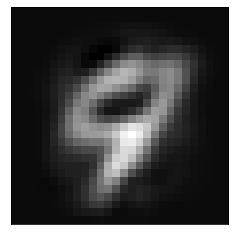

  0%|          | 2/1000 [00:00<02:42,  6.15it/s]


Relative Change [X]:  0.9870153577373326
Relative Change [Y]:  0.24495019943617855


  5%|▍         | 49/1000 [00:05<01:38,  9.65it/s]

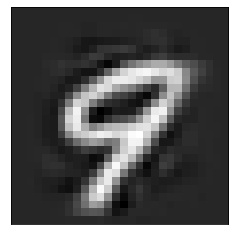

  5%|▌         | 52/1000 [00:05<01:51,  8.48it/s]


Relative Change [X]:  0.0018596469416642639
Relative Change [Y]:  0.003573142563959225


 10%|█         | 100/1000 [00:10<02:06,  7.12it/s]

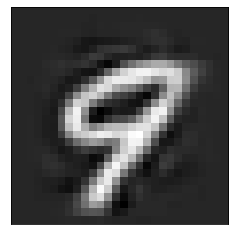

 10%|█         | 102/1000 [00:11<02:59,  5.01it/s]


Relative Change [X]:  0.00043156660971184306
Relative Change [Y]:  0.0008912192988924191


 15%|█▌        | 150/1000 [00:20<02:31,  5.62it/s]

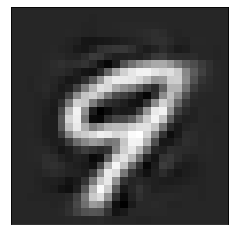

 15%|█▌        | 152/1000 [00:21<02:52,  4.92it/s]


Relative Change [X]:  0.00019616556851675553
Relative Change [Y]:  0.00034902871264517923


 20%|█▉        | 199/1000 [00:25<01:14, 10.71it/s]

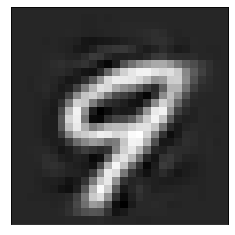

 20%|██        | 203/1000 [00:26<01:22,  9.69it/s]


Relative Change [X]:  0.00011571802506527842
Relative Change [Y]:  0.0001691421444297761


 25%|██▍       | 249/1000 [00:30<01:12, 10.37it/s]

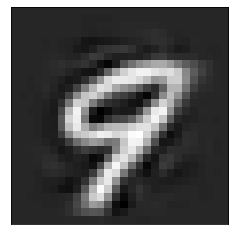

 25%|██▌       | 253/1000 [00:31<01:17,  9.63it/s]


Relative Change [X]:  7.200423209537816e-05
Relative Change [Y]:  9.088848954932937e-05


 30%|██▉       | 299/1000 [00:35<01:03, 10.96it/s]

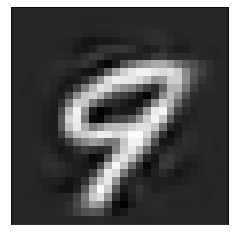

 30%|███       | 302/1000 [00:35<01:15,  9.22it/s]


Relative Change [X]:  4.471406305923809e-05
Relative Change [Y]:  5.13830984061903e-05


 35%|███▍      | 349/1000 [00:40<01:02, 10.34it/s]

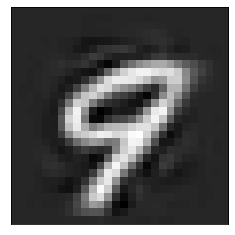

 35%|███▌      | 353/1000 [00:40<01:07,  9.64it/s]


Relative Change [X]:  2.7477814144510334e-05
Relative Change [Y]:  2.981318268680414e-05


 40%|████      | 400/1000 [00:44<00:53, 11.13it/s]

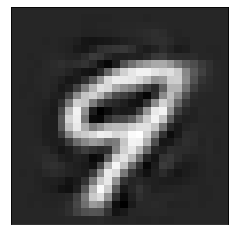

 40%|████      | 403/1000 [00:45<01:03,  9.45it/s]


Relative Change [X]:  1.673670905029851e-05
Relative Change [Y]:  1.7540424256578858e-05


 45%|████▌     | 450/1000 [00:49<00:51, 10.72it/s]

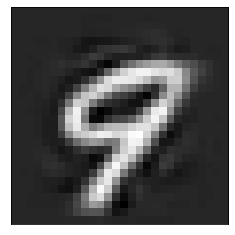

 45%|████▌     | 452/1000 [00:50<00:59,  9.20it/s]


Relative Change [X]:  1.0132499283089355e-05
Relative Change [Y]:  1.0400192232610037e-05


 50%|████▉     | 499/1000 [00:54<00:46, 10.84it/s]

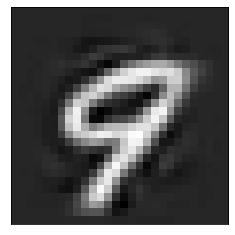

 50%|█████     | 503/1000 [00:55<00:49, 10.02it/s]


Relative Change [X]:  6.110482263036822e-06
Relative Change [Y]:  6.194043142620813e-06


 55%|█████▍    | 549/1000 [00:59<00:40, 11.25it/s]

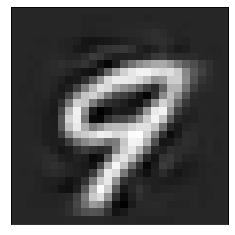

 55%|█████▌    | 552/1000 [00:59<00:47,  9.45it/s]


Relative Change [X]:  3.676113376606542e-06
Relative Change [Y]:  3.698574125293068e-06


 60%|█████▉    | 599/1000 [01:04<00:37, 10.66it/s]

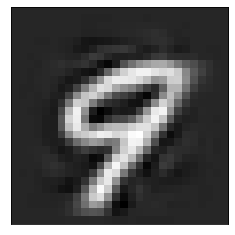

 60%|██████    | 603/1000 [01:04<00:39,  9.93it/s]


Relative Change [X]:  2.208331634103925e-06
Relative Change [Y]:  2.211869434290768e-06


 65%|██████▌   | 650/1000 [01:09<00:34, 10.28it/s]

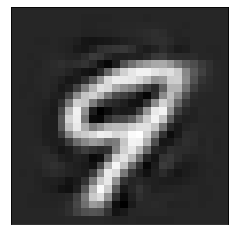

 65%|██████▌   | 652/1000 [01:09<00:39,  8.91it/s]


Relative Change [X]:  1.3254196454624868e-06
Relative Change [Y]:  1.3239743898591458e-06


 70%|███████   | 700/1000 [01:14<00:28, 10.71it/s]

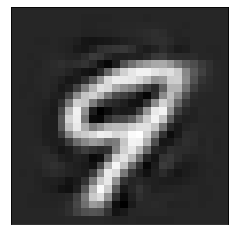

 70%|███████   | 702/1000 [01:14<00:31,  9.42it/s]


Relative Change [X]:  7.950778249167611e-07
Relative Change [Y]:  7.929304779804721e-07


 75%|███████▍  | 749/1000 [01:19<00:24, 10.40it/s]

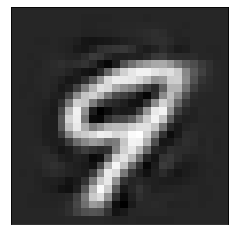

 75%|███████▌  | 753/1000 [01:19<00:26,  9.37it/s]


Relative Change [X]:  4.7678856394915314e-07
Relative Change [Y]:  4.7504122212003683e-07


 80%|███████▉  | 799/1000 [01:24<00:18, 10.76it/s]

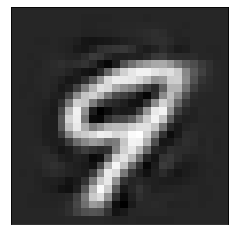

 80%|████████  | 803/1000 [01:25<00:19,  9.88it/s]


Relative Change [X]:  2.858629775532573e-07
Relative Change [Y]:  2.846502919524607e-07


 85%|████████▌ | 850/1000 [01:29<00:14, 10.39it/s]

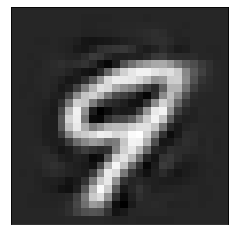

 85%|████████▌ | 852/1000 [01:30<00:17,  8.57it/s]


Relative Change [X]:  1.7137186600992894e-07
Relative Change [Y]:  1.705855935725757e-07


 90%|█████████ | 900/1000 [01:34<00:09, 10.92it/s]

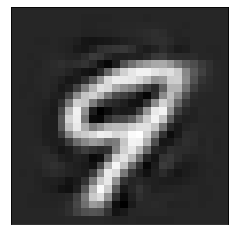

 90%|█████████ | 903/1000 [01:35<00:10,  9.41it/s]


Relative Change [X]:  1.0272848046485908e-07
Relative Change [Y]:  1.0223585793073504e-07


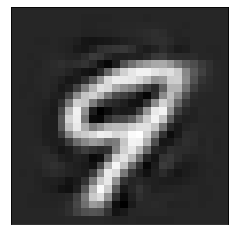

 90%|█████████ | 904/1000 [01:35<00:10,  9.49it/s]


Relative Change [X]:  9.96220047224915e-08
Relative Change [Y]:  9.91433447494975e-08


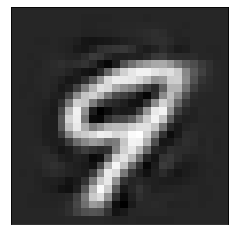

In [ ]:
k = int(comp_fact * n_features)
embed_mat, decomp_mat = ALS(dataset, k, lam, maxit, tol)

# Reconstuction from ALS

In [ ]:
reconstructed_dataset = embed_mat @ decomp_mat.T

for i in range(10):
  plot_two_image_vector(reconstructed_dataset[i], "Decompressed Image", dataset[i], "Original Image")

# for i in range(10):
#   plot_two_image_vector(dataset[i], "Original (in training set)", reconstructed_dataset[i], "Reconstructed" , figsize=(12, 12), titlesize=20)

# Finding an Embedding Matrix For a New Dataset

## Compression Matrix with Least Squares

To find an embedding matrix to embed the dataset, we just need to solve the  following least squares problem:
$$ \underset{M}{\text{minimize}} \quad \quad ||RM - E||^2_F + \frac{\lambda}{2} ||M||^2_F $$
where $R$ is the dataset and $E$ is the embedding matrix calculated by the matrix factorization.
$$ M = \left(R^T R + \lambda I\right)^{-1} R^T E $$

Note: $M$ is the compression matrix.

In [ ]:
def calc_M(R, E, lam):
  return np.linalg.inv(R.T @ R + lam * np.identity(n_features)) @ R.T @ E

Let's try compressing a new set of digits from MNIST that we haven't seen before using the learned compression matrix $M$ or "comp_mat".

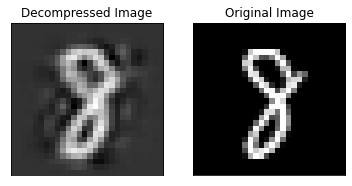

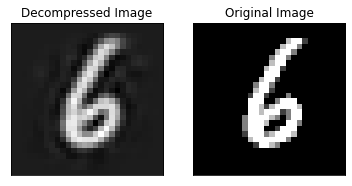

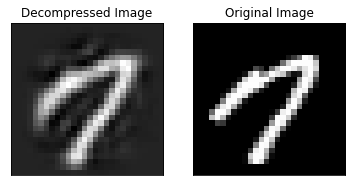

In [ ]:
test_dataset = create_dataset(train_loader, batch_num=1)
# test_dataset = dataset

# Directly solve pseudoinverse of decompression
comp_mat = calc_M(dataset, embed_mat, lam)

embedded_dataset = test_dataset @ comp_mat

reconstructed_dataset_ls = embedded_dataset @ decomp_mat.T

for i in range(10):
  plot_two_image_vector(reconstructed_dataset_ls[i], "Decompressed Image", test_dataset[i], "Original Image")

In [ ]:
# Compare size of compressed dataset to original
n_original_dataset = dataset.shape[0] * dataset.shape[1]
n_compressed_dataset = embed_mat.shape[0] * embed_mat.shape[1] + decomp_mat.shape[0] * decomp_mat.shape[1]
print(f"Number of elements in original dataset: {n_original_dataset}")
print(f"Number of elements in compressed dataset: {n_compressed_dataset}")
print(f"Compression ratio: {n_original_dataset / n_compressed_dataset}")

Number of elements in original dataset: 3136000
Number of elements in compressed dataset: 373152
Compression ratio: 8.404081982677301


## Compression Matrix with Left Inverse

The left inverse is a more straightforward and simpler alternative to finding the compression matrix from the decompression matrix. It also works better by a small margin.

In [ ]:
# Assumes the matrix has full column rank
# Reference: https://ocw.mit.edu/courses/18-06sc-linear-algebra-fall-2011/0550c89b69c99e97dcbf52074e293308_MIT18_06SCF11_Ses3.8sum.pdf
def leftinv(A):
    return np.linalg.inv(A.T @ A) @ A.T 

# Use the left inverse to find the compression matrix
# Decompression: n x k (full column rank)
comp_mat2 = leftinv(decomp_mat)

embedded_dataset_linv = test_dataset @ comp_mat2.T
reconstructed_dataset_linv = embedded_dataset_linv @ decomp_mat.T

In [ ]:
for i in range(3):
  plot_two_image_vector(reconstructed_dataset_linv[i], "Decompressed Image", test_dataset[i], "Original Image")

# for i in range(30, 50):
#   plot_two_image_vector(test_dataset[i], "Original (outside training set)", reconstructed_dataset_linv[i], "Reconstruction", figsize=(12, 12), titlesize=20)

# Comparing Least Squares and Left Inverse

In [ ]:
linv_vs_ls = mean_l2diff(reconstructed_dataset_ls, reconstructed_dataset_linv)
linv_err = mean_l2diff(reconstructed_dataset_linv, test_dataset)
ls_err = mean_l2diff(reconstructed_dataset_ls, test_dataset)

print("Left-inverse reconstruction error: ", linv_err)
print("Least-squares reconstruction error: ", ls_err)
print("Left-inverse and Least Square Reconstruction Difference: ", linv_vs_ls)

Left-inverse reconstruction error:  2.43086690542434
Least-squares reconstruction error:  2.4348596975329215
Left-inverse and Least Square Reconstruction Difference:  0.13825877799132893


In [ ]:
ls_linv_Cdiff = np.linalg.norm(comp_mat - comp_mat2.T, ord="fro")
print("Left-inverse vs Least Square Compression Matrix Difference: ", ls_linv_Cdiff)

Left-inverse vs Least Square Compression Matrix Difference:  0.06349189692541396


Let's compared the reconstructed images from least squares and left inverse. You can see that they are pretty similar.

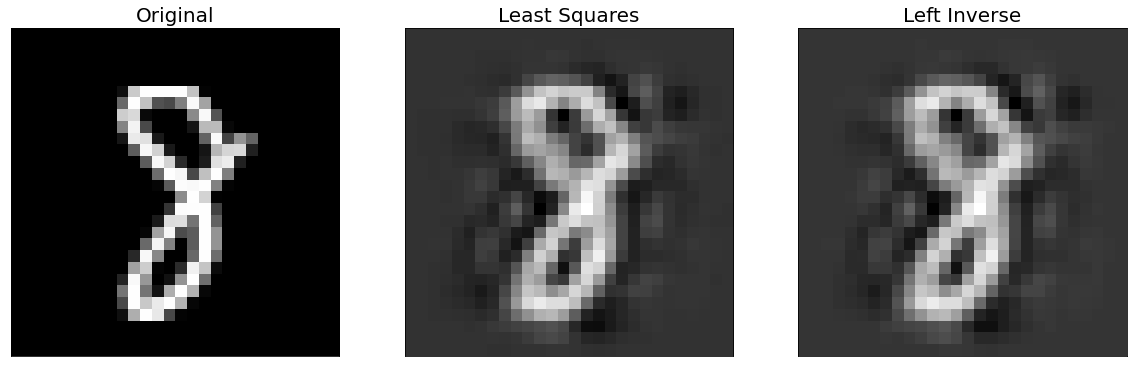

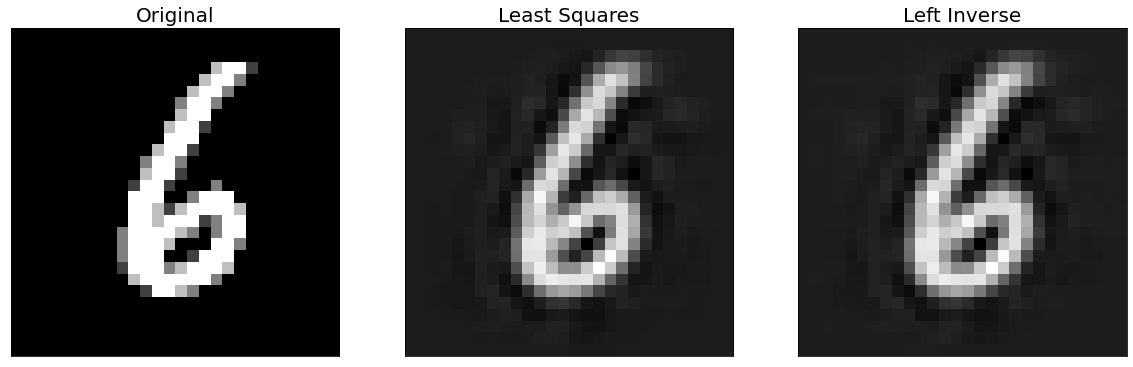

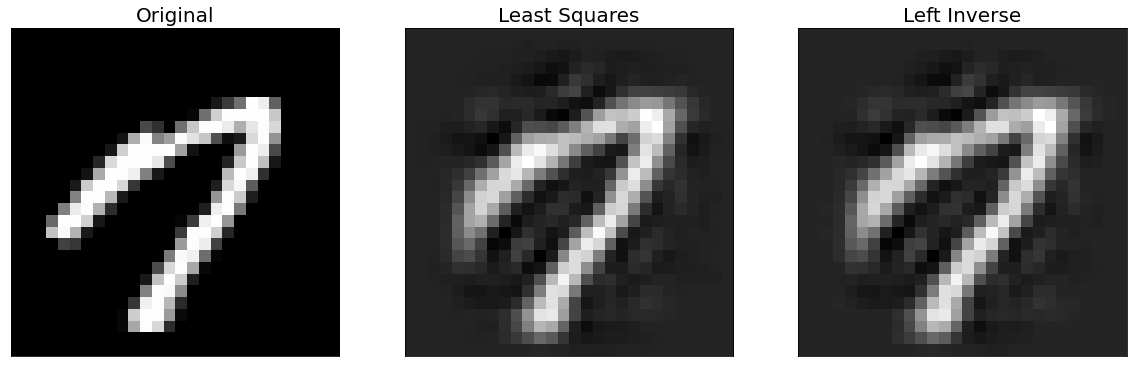

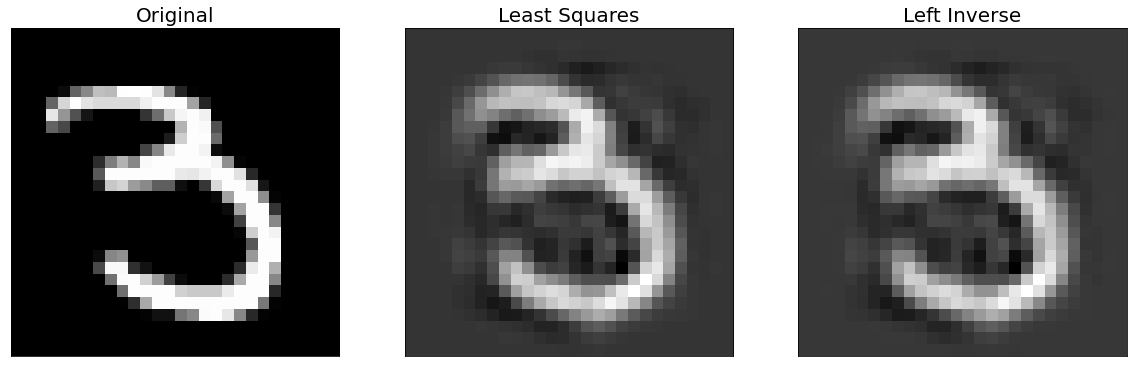

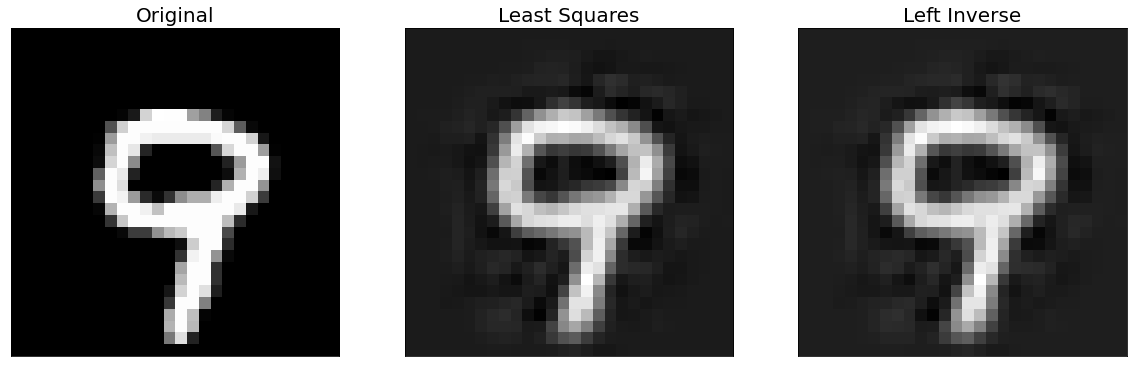

In [ ]:
# for i in range(5):
#     images = [test_dataset[i], reconstructed_dataset_ls[i], reconstructed_dataset_linv[i]]
#     titles = ["Original", "Least Squares", "Left Inverse"]
#     plot_image_vectors(images, titles)

for i in range(5):
    images = [test_dataset[i], reconstructed_dataset_ls[i], reconstructed_dataset_linv[i]]
    titles = ["Original", "Least Squares", "Left Inverse"]
    plot_image_vectors(images, titles, figsize=(20, 20), titlesize=20)

# Visualizing the Compression Matrix

We can visualize some of basis images that are used for compression.

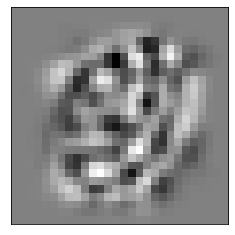

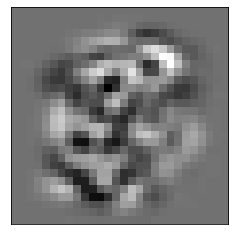

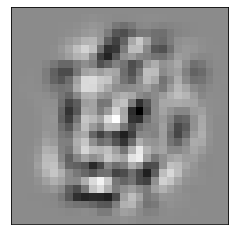

In [ ]:
# TODO: if time, from an image, find the top-N basis elements that are the most important and
# plot them beside the original image
for i in range(3):
  plot_image_vector(comp_mat2.T[:,i]) #comp_mat for ls method, #comp_mat2.T for linv method

Let's visualize the contribution of each pixel in the uncompressed form to the compressed representation (embedding), as a heatmap.

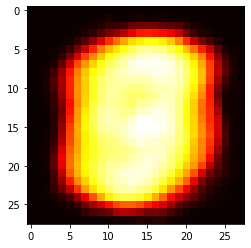

In [ ]:
# Calculate contribution of each pixel by taking the l2 norm of its weights
# towards all the compressed pixels. In our case, this corresponds to a single
# row of the D matrix (which is n x k) for each pixel.
contri_hmap = np.linalg.norm(decomp_mat, ord=2, axis=1).reshape(IMAGE_SHAPE)

# Looks like a freshly cooked Lays chip to me
plt.imshow(contri_hmap, cmap='hot', interpolation='nearest')
plt.show()

# Denoising

The reconstructed images are blurry and noisy especially at high compression rates. Using denoising can likely produce sharper images with less noise. Note that the image does NOT contain Gaussian noise, so this method is limited. We can still produce some interesting results, however.

## 1D Total Variation Denoising

In [ ]:
def D(x):
    # x is the input vector with length N
    # compute res, an output vector with length N-1

    return np.array([x[i] - x[i-1] for i in range(1, len(x))])
  
def DT(y):
    # y is the input vector with length N-1
    # compute res, an output vector with length N
    
    return np.array([-y[0]] + [-y[i] + y[i-1] for i in range(1, len(y))] + [y[-1]])
  
def DDT(x):
    # x is the input vector with length N-1
    # compute res, an output vector with length N-1
    
    return D(DT(x))

def prox_gd(f,fp,prox,y,A,lam,x_init,ss,maxit,tol):
    # f is the total objective
    # fp is the gradient for the differentiable part
    # prox is the proximal operator

    x = x_init
    prev_obj = -1e9
    obj = f(y, A, x)
    it = 0

    while(it < maxit and np.abs(obj - prev_obj)/obj > tol):
      z = x - ss * fp(y, A, x)
      x = prox(z, lam, ss)
      prev_obj = obj
      obj = f(y, A ,x)
      it += 1

    return x

f = lambda y, A, gam: 1/2 * np.dot(y - DT(gam), y - DT(gam))
fp = lambda y, A, gam: -D(y - DT(gam))
prox = lambda gam, lam, ss: np.clip(gam, -lam, lam)


In [ ]:
maxit = 10000
tol = 1e-9
ss = 0.25
lam = 0.1
gam_init = np.zeros(n_features-1)

titles = ["Original", "Reconstructed", "Denoised", "Filtered"]
imgs = []

high_pass_thresh = 0.2
amp_factor = 1.25

recover_primal = lambda y, gam: y - DT(gam)

for i in range(5):
  signal = reconstructed_dataset_linv[i]

  # Denoise flattened image (rows)
  gam = prox_gd(f, fp, prox, signal, None, lam, gam_init, ss, maxit, tol)
  recovered_signal = recover_primal(signal, gam)

  signal_t = np.reshape(recovered_signal, IMAGE_SHAPE).T.flatten()

  # Denoise flattened image transpose (columns)
  gam = prox_gd(f, fp, prox, signal_t, None, lam, gam_init, ss, maxit, tol)
  recovered_signal = recover_primal(signal_t, gam)

  denoised_img = np.reshape(recovered_signal, IMAGE_SHAPE).T.flatten()
  
  # High pass filter 
  filtered_img = denoised_img.copy()
  filtered_img[filtered_img < high_pass_thresh] = 0

  # Amplification
  amp = amp_factor / np.max(filtered_img)
  filtered_img = np.minimum(filtered_img * amp, 1)

  # Store the different versions of the image
  imgs.append([test_dataset[i], reconstructed_dataset_linv[i], denoised_img, filtered_img])

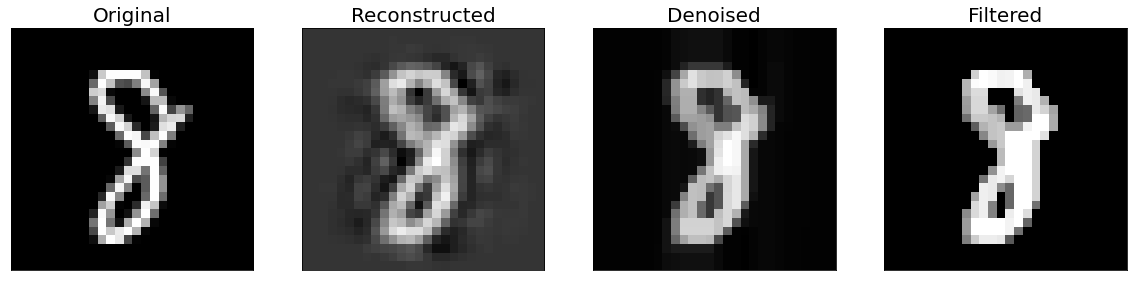

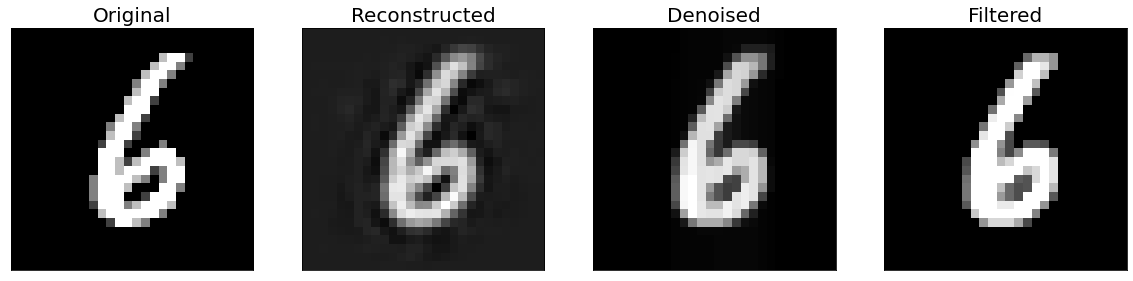

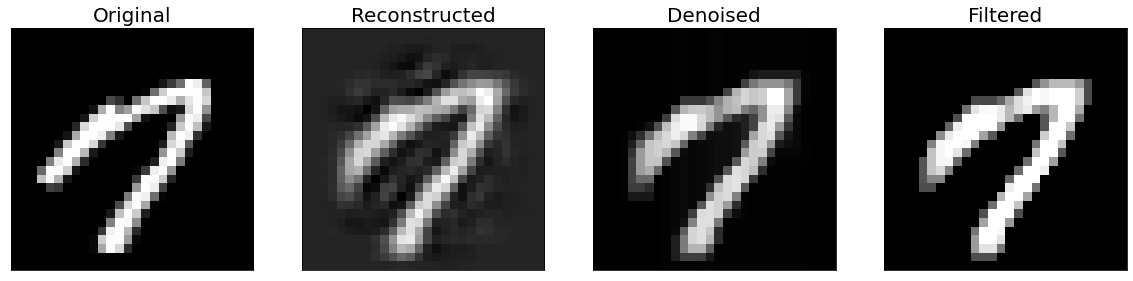

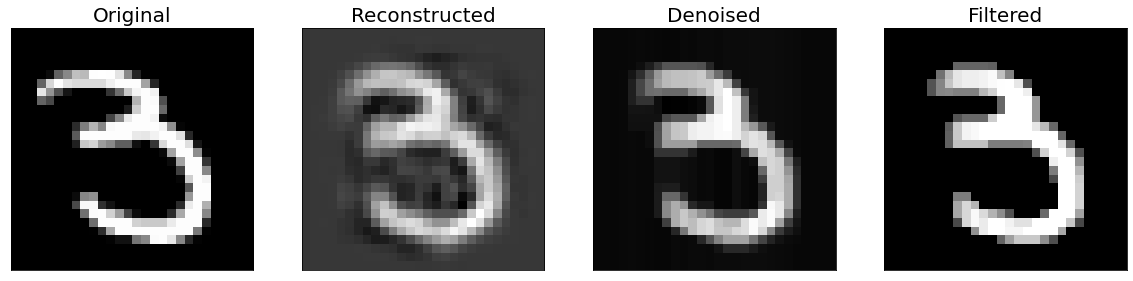

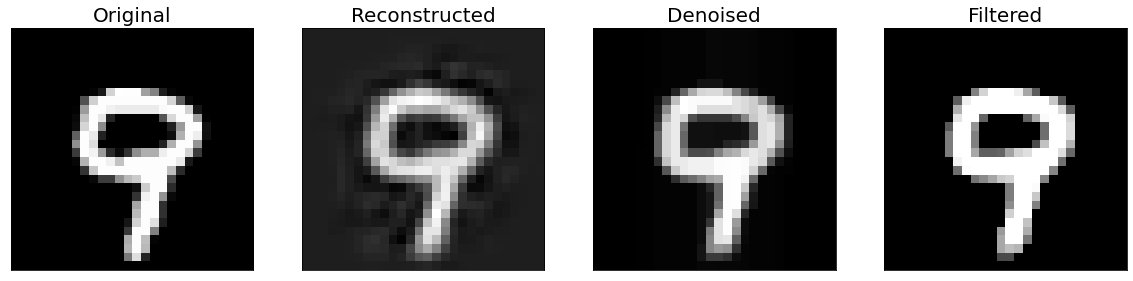

In [ ]:
for versions in imgs:
  plot_image_vectors(versions, titles, figsize=(20, 20), titlesize=20)

# Trying different compression factors

In [ ]:
lam = 1
comp_facts = [0.5, 0.2, 0.1, 0.05]
tol = 1e-7
maxit = 2000

ls_errs = list()
linv_errs = list()
comp_ratios = list()

reconstructions_ls = list()
reconstructions_linv = list()

for comp_fact in comp_facts:

  print("For comp_fact = ", comp_fact, " ------------------------------------------------------")

  k = int(comp_fact * n_features)
  embed_mat_, decomp_mat_ = ALS(dataset, k, lam, maxit, tol, report = False)

  n_original_dataset = test_dataset.shape[0] * test_dataset.shape[1]
  n_compressed_dataset = embed_mat_.shape[0] * embed_mat_.shape[1] + decomp_mat_.shape[0] * decomp_mat_.shape[1]
  print(f"Number of elements in original dataset: {n_original_dataset}")
  print(f"Number of elements in compressed dataset: {n_compressed_dataset}")
  print(f"Compression ratio: {n_original_dataset / n_compressed_dataset}")

  comp_ratios.append(n_original_dataset / n_compressed_dataset)

  comp_mat = calc_M(dataset, embed_mat_, lam)
  embedded_dataset_ls = test_dataset @ comp_mat
  reconstructed_dataset_ls = embedded_dataset_ls @ decomp_mat_.T
  reconstructions_ls.append(reconstructed_dataset_ls)

  comp_mat2 = leftinv(decomp_mat_)
  embedded_dataset_linv = test_dataset @ comp_mat2.T
  reconstructed_dataset_linv = embedded_dataset_linv @ decomp_mat_.T
  reconstructions_linv.append(reconstructed_dataset_linv)

  linv_err = mean_l2diff(reconstructed_dataset_linv, test_dataset)
  ls_err = mean_l2diff(reconstructed_dataset_ls, test_dataset)

  ls_errs.append(ls_err)
  linv_errs.append(linv_err)

  print("Left-inverse reconstruction error: ", linv_err, " | Least-squares reconstruction error: ", ls_err)
  print("--------------------------------------------------------------------------------------")


In [ ]:
import matplotlib.pyplot as plt

# Plot a simple line chart without any feature
plt.figure(figsize=(16, 12))

  
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(comp_facts, ls_errs, label='Linear Regression Error')
ax.plot(comp_facts, linv_errs, label='Left Inverse Error')
ax.set_title('Error vs Compression Factor', fontsize = 20)
ax.set_xlabel('comp_fact', fontsize = 18)
ax.set_ylabel('error', fontsize = 18)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.legend(prop={'size': 20})
  
plt.show()

In [ ]:
titles = ["Original", "2x Compression", "5x Compression", "10x Compression","20x Compression"]

for i in range(20):
  imgs = [test_dataset[i], reconstructions_linv[0][i], reconstructions_linv[1][i], reconstructions_linv[2][i], reconstructions_linv[3][i]]
  plot_image_vectors(imgs, titles, figsize=(20, 20), titlesize=20)


# Miscellaneous

## Finding Compression Matrix using Gradient Descent

This turned out to be unnecessary, because we found a closed form solution for the compression matrix.

In [ ]:
def gd(f,fp,y,A,xinit,lam,ss,maxit,tol):
  """
  Note that ss changes to ss_init
  ss_init is the starting stepsize for backtracking
  """

  i = 0
  obj = f(y, A, xinit, lam)
  prev_obj = 1e9
  x = xinit
  alpha = 0.5
  beta = 0.5

  for i in tqdm(range(maxit)):
    if(abs((obj - prev_obj)/prev_obj) < tol):
      break

    df = fp(y, A, x, lam)
    x = x - ss * df
    i += 1
    
    prev_obj = obj
    obj = f(y, A, x, lam)

    i += 1

  return x

lam = 1
tol = 1e-6

# Lipschitz (a bit too conservative so its very slow)
_, S, _ = np.linalg.svd(dataset.T @ dataset)
ss = 1 / S[0]

M_init = np.zeros((n_features, k))
maxit = 1000

# Learn a matrix to embed a dataset
p = lambda E, R, M, lam : np.linalg.norm(R @ M - E, ord='fro') ** 2 + lam / 2 * np.linalg.norm(M, ord='fro') ** 2
p_grad = lambda E, R, M, lam : R.T @ (R @ M - E) + lam * M

#Use gradient descent
comp_mat = gd(p, p_grad, E, dataset, M_init, lam, ss, maxit, tol)